In [5]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [6]:
#from nilmtk.dataset_converters import convert_refit
#convert_refit(r"C:\Users\jenic\FINAL\REFIT", 'REFIT.h5')

In [7]:
from nilmtk.dataset_converters import convert_refit
convert_refit(r"C:\Users\jenic\FINAL\REFIT", 'Data.h5')

Loading house 17... Using CLEAN filenames (CLEAN_HouseXX.csv)
1 2 3 4 
Loaded metadata


AttributeError: 'NoneType' object has no attribute '_v_attrs'

In [8]:
train = DataSet(r"C:\Users\jenic\Data.h5")
test = DataSet(r"C:\Users\jenic\Data.h5")

Closing remaining open files:C:\Users\jenic\AppData\Local\Temp\nilmtk-qb38e4wg.h5...doneData.h5...done


In [5]:
building = 17

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REFIT', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REFIT', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=2)])
  ElecMeter(instance=5, building=1, dataset='REFIT', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REFIT', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REFIT', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=9, building=1, dataset='REFIT', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=10, building=1, data

C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


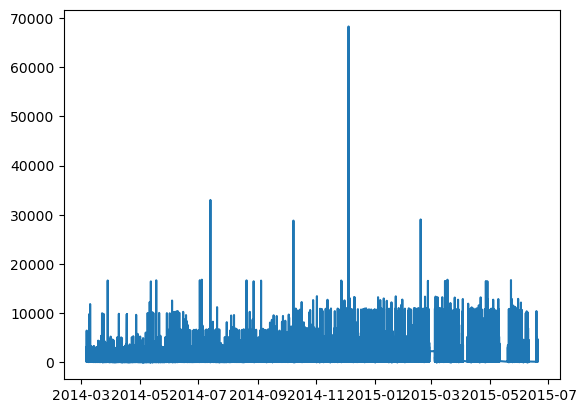

In [6]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
%matplotlib inline

train_elec = train.buildings[1].elec

print(train_elec)
plt.plot(train_elec[1].power_series_all_data())

In [7]:
train.set_window(start='2014-03-15',end='2015-03-16')
train_elec = train.buildings[1].elec

test.set_window(start='2014-03-15',end='2015-03-16')
test_elec = test.buildings[1].elec

In [8]:
mains=train_elec.mains()
submeters=train_elec.submeters()

In [9]:
mains.available_ac_types('power')

['active']

In [10]:
submeters.available_ac_types('power')

['active']

In [11]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

CO

In [12]:
classifiers = {'CO':CombinatorialOptimisation()}#, 'FHMM':FHMM()}
predictions = {}
sample_period = 200
for clf_name, clf in classifiers.items():
    print(clf_name)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

CO
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='REFIT', appliances=[Appliance(type='fridge', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=4, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=2)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REFIT', appliances=[Appliance(type='washer dryer', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REFIT', appliances=[Appliance(type='washing machine', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REFIT', appliances=[Appliance(type='computer', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REFIT', appliances=[Appliance(type='television', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=10, building=1, dataset='REFIT', appliances=[Appliance(type='electric space heater', instance=1)])'


C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\jenic\anaconda3\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Done training!
Runtime = 32.3512978553772 seconds.
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='REFIT', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='REFIT', appliances=[Appliance(type='freezer', instance=2)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REFIT', appliances=[Appliance(type='washer dryer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REFIT', appliances=[Appliance(type='washing machine', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REFIT', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REFIT', appliances=[Appliance(type='computer', instance=1)])'
E

In [13]:
appliance_labels = [m.label() for m in gt.columns.values]

In [14]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels

In [15]:
gt.head()

,Fridge,Freezer,Freezer,Washer dryer,Washing machine,Dish washer,Computer,Television,Electric space heater
Unix,,,,,,,,,
2014-03-15 00:00:00+00:00,0.0,79.107143,0.0,0.0,3.000000,25.142857,2.142857,0.0,0.785714
2014-03-15 00:03:20+00:00,0.0,77.440000,0.0,0.0,3.040000,25.160000,2.040000,0.0,0.840000
2014-03-15 00:06:40+00:00,0.0,76.450000,0.0,0.0,3.000000,25.000000,2.000000,0.0,0.900000
2014-03-15 00:10:00+00:00,0.0,75.413793,0.0,0.0,3.103448,24.965517,2.034483,0.0,0.896552
2014-03-15 00:13:20+00:00,0.0,74.904762,0.0,0.0,3.000000,25.000000,2.333333,0.0,0.857143


In [16]:
predictions['CO'].head()

,Fridge,Freezer,Freezer,Washer dryer,Washing machine,Dish washer,Computer,Television,Electric space heater
Unix,,,,,,,,,
2014-03-15 00:00:00+00:00,0.0,79.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0
2014-03-15 00:03:20+00:00,56.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
2014-03-15 00:06:40+00:00,0.0,33.0,0.0,0.0,0.0,55.0,0.0,0.0,43.0
2014-03-15 00:10:00+00:00,0.0,79.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0
2014-03-15 00:13:20+00:00,0.0,79.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0


In [20]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)

In [21]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

,CO
Fridge,80.013848
Freezer,217.680560
Washer dryer,295.100734
Washing machine,138.745378
Dish washer,25.793164
Computer,168.544110
Television,227.465805
Electric space heater,105.864832


In [ ]:
appliance_labels = [m.label() for m in gt.columns.values]

HART85

In [25]:
from nilmtk.legacy.disaggregate.hart_85 import Hart85

h = Hart85()

In [26]:
#Training the model using HART85 disaggregation method

h.train(mains,columns=[('power','active')])

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


AttributeError: type object 'object' has no attribute 'dtype'

In [3]:
import h5py
import numpy as np

# Open the original file jointly with new file, with `float32` at the end.
with h5py.File(train, 'r') as f, h5py.File(newfile[:-3]+'_float32.h5', 'w') as newf:
    # `head` is some directory structure
    # Create groups to follow the same directory structure
    newf.create_group(head)

    # When it comes time to create a dataset, make the cast here.
    newdata = (f[head+'/NewData'].value).astype('float32')
    newf.create_dataset(head+'/NewData', data=newdata, dtype='f4')

    # Proceed for all other datasets.

NameError: name 'train' is not defined